#### torch.nn 없이 구현

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


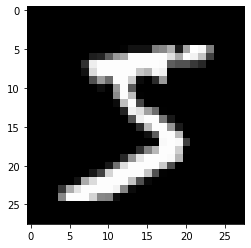

In [4]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [5]:
import torch


x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape

print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [6]:
import math


weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [7]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)    # @는 dot product 연산

In [8]:
bs = 64    # 배치 사이즈

xb = x_train[0:bs]    # x로부터 미니배치(mini-batch) 추출
preds = model(xb)     # 예측
print(preds[0], preds.shape)

tensor([-2.1262, -2.5007, -2.2758, -3.0888, -1.8649, -2.7529, -2.8904, -2.1869,
        -2.0178, -2.0327], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [9]:
# negative log-likelihood (음의 로그 우도) 손실함수로 사용
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [10]:
# 무작위 모델에 대한 손실 점검
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.4916, grad_fn=<NegBackward>)


In [11]:
# 정확도 계산 함수
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

# 무작위 모델에 대한 정확도 점검
print(accuracy(preds, yb))

tensor(0.0312)


In [12]:
from IPython.core.debugger import set_trace


lr = 0.5      # 학습률(learning rate)
epochs = 2    # 훈련에 사용할 에포크(epochs) 수

# 훈련 루프
for epoch in range(epochs):
    for i in range((n-1) // (bs+1)):
        # set_trace()
        
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        
        pred = model(xb)    # 얘측
        loss = loss_func(pred, yb)    # 손실 게산
        
        # 모델의 기울기 업데이트
        # 다음 기울기의 계산에 기록되지 않도록 torch.no_grad() context manager 내에서 실행
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [13]:
# 학습된 모델에 대한 손실, 정확도 점검
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.2762, grad_fn=<NegBackward>) tensor(0.9219)


#### torch.nn.functional 사용

In [14]:
import torch.nn.functional as F


# 손실 함수 cross-entropy로 변환
loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias    # 소프트맥스 호출 x

In [15]:
# 그 전과 동일한 결과 갑
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.2762, grad_fn=<NllLossBackward>) tensor(0.9219)


#### nn.Module을 이용하여 리팩토링

In [16]:
from torch import nn


class Mnist_Logisic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [17]:
model = Mnist_Logisic()

print(loss_func(model(xb), yb))

tensor(2.3642, grad_fn=<NllLossBackward>)


In [18]:
# 훈련 루프 함수
def fit():
    for epoch in range(epochs):
        for i in range((n-1) // (bs+1)):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
                
fit()

In [19]:
print(loss_func(model(xb), yb))

tensor(0.2827, grad_fn=<NllLossBackward>)


#### nn.Linear를 이용하여 리팩토링

In [20]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)    # xb @ self.weights + self.bias
        
    def forward(self, xb):
        return self.lin(xb)
    
model = Mnist_Logisic()
print(loss_func(model(xb), yb))

tensor(2.2977, grad_fn=<NllLossBackward>)


In [21]:
fit()

print(loss_func(model(xb), yb))

tensor(0.2781, grad_fn=<NllLossBackward>)


#### optim을 이용하여 리팩토링

In [22]:
from torch import optim


# 모델과 옵티마이저를 얻는 함수
def get_model():
    model = Mnist_Logisic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n-1) // (bs+1)):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3693, grad_fn=<NllLossBackward>)
tensor(0.2768, grad_fn=<NllLossBackward>)


#### DataSet을 이용하여 리팩토링

In [23]:
# 텐서를 감싸는 (wrapping)Dataset 
from torch.utils.data import TensorDataset


# 하나의 TensorDataset에 합쳐서 반복, 슬라이스를 편하게 함
train_ds = TensorDataset(x_train, y_train)

model, opt = get_model()

for epoch in range(epochs):
    for i in range((n-1) // (bs+1)):
        start_i = i * bs
        end_i = start_i + bs
        xb, yb = train_ds[start_i:end_i]    # 함께 움직이는 x와 y
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(0.2765, grad_fn=<NllLossBackward>)


#### DataLoader를 이용하여 리팩토링

In [24]:
# DataLoader은 배치관리를 담당
# Dataset으로부터 DataLoader 생성이 가능
from torch.utils.data import DataLoader


train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(0.0805, grad_fn=<NllLossBackward>)


#### 검증(validation) 추가

In [25]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

# 검증 과정은 역전파가 없으므로(메모리 절약) batch_size를 2배로 늘려 손실 계산을 빠르게 함
# 검증 데이터 셋은 섞든 섞지 않던 동일하므로, 시간이 걸리는 shuffle 과정은 생략
valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)

model, opt = get_model()
for epoch in range(epochs):
    model.train()    # 훈련전에 항상 호출 
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    model.eval()    # 추론(inference) 전에 항상 호출
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)
        
    print(epoch, valid_loss/len(valid_dl))

0 tensor(0.3824)
1 tensor(0.2778)


#### fit()과 get_data() 생성

In [26]:
def loss_batch(midel, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [27]:
import numpy as np


# 모델을 훈련하고 각 에포크에 대한 훈련 및 검증 손실을 계산하는 함수
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
            
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
            val_loss = np.sum(np.multiply(losses, nums) / np.sum(nums))
            
            print(epoch, val_loss)

In [28]:
# 학습 및 검증 데이터셋에 대한 dataloader를 출력하는 함수
def get_data(train_ds, valid_ds, bs):
    return(
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs*2)
    )

In [29]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.33509899317026137
1 0.3053603762745857


#### CNN
3개의 컨볼루션 레이어로 신경망 구축

In [30]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))
    
model = Mnist_CNN()
lr = 0.1
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.41251634149551386
1 0.2495519159555435


#### nn.Sequential

In [31]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
def preprocess(x):
    return x.view(-1, 1, 28, 28)

model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.39287250478267666
1 0.26190395725369453


#### DataLoader 감싸기

In [32]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))
            
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    Lambda(lambda x: x.view(x.size(0), -1))
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 1.631989006996155
1 1.4938864263534544
